In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import time      as clock
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr

/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None # 5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'dmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'w_diap'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None #
ref_year  = None # [1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
which_dpi = 300
do_rescale= None #'log10'
proj      = 'pc' #'pc'
do_contour= True
do_plot   = 'tcf'
which_isopyc = 36.72
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl != None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path != None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        
    
#______________________________________________________________________________________________________        
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [5]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
# load divergence of density class
ts = clock.time()
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data_list.append( tpv.load_dmoc_data(mesh, datapath, descript, year, 'dmoc', std_dens, do_wdiap=True, do_info=False) ) 
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data_list[-1] is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))    
    
#___COMPUTE DIAPYCNAL VERTICAL VELOCITY________________________________________________________________
# finds closest index of isopycnal class
ndens       = len(std_dens)
idx_isopycn = np.argmin(np.abs(np.array(std_dens)-which_isopyc))
print(' sigma_2 = {:5.2f} kg/m^3'.format(std_dens[idx_isopycn]))

# integrate (xr.sum) divergence over all density classes below idx_isopycn     
ts = clock.time()
wdiap_list = list()
for ii, data in enumerate(data_list):
    wdiap = data.isel(ndens=range(ndens-1,idx_isopycn-1,-1)).sum(dim='ndens',skipna=True).rename({'dmoc':'w_diap'}).load()
    wdiap[list(wdiap.keys())[0]] = wdiap[list(wdiap.keys())[0]].assign_attrs({'description':'diapycnal velocity',
                                                                              'long_name'  :'diapycnal velocity',
                                                                              'short_name' :'w_diapyc',
                                                                              'units'      :'m/s',
                                                                              'str_ldep'   :', $\sigma_{{2}}$={:5.2f}kg/m³'.format(std_dens[idx_isopycn])})
    if (ref_path != None) and (ref_path != "None"): 
        if ii == 0: 
            wdiap_ref = wdiap.copy()
            if do_reffig: wdiap_list.append(wdiap_ref) 
        else:        
            wdiap_list.append( tpv.do_anomaly(wdiap, wdiap_ref) )
    else:                                                   
        wdiap_list.append( wdiap )
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))           

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elapsed time: 0.03526768684387207 min
 sigma_2 = 36.72 kg/m^3
 --> elapsed time: 0.06926446755727132 min


In [6]:
# do regular binning of diapycnal velocities
Rearth     = 6371e3
rad        = np.pi/180
dlon, dlat = 2.0, 2.0
lon_reg    = np.arange(-180, 180+dlon, dlon)
lat_reg    = np.arange( -90,  90+dlat, dlat)
mlon_reg , mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0
nmlon_reg, nmlat_reg= mlon_reg.size, mlat_reg.size

# computre area of reg grid 
dx, dy = np.pi*Rearth*dlon/180*np.cos(mlat_reg*rad), np.pi*Rearth*dlat/180
area_reg = np.transpose(np.ones((nmlon_reg, nmlat_reg))*dy * dx)

#compute bins 
bin_x, bin_y = np.zeros(len(mesh.n_x))-1, np.zeros(len(mesh.n_y))-1
for ni in range(nmlon_reg): bin_x[ (mesh.n_x-lon_reg[ni])*(mesh.n_x-lon_reg[ni+1])<=0 ] = ni
for ni in range(nmlat_reg): bin_y[ (mesh.n_y-lat_reg[ni])*(mesh.n_y-lat_reg[ni+1])<=0 ] = ni
#_______________________________________________________________________________________________________________
    
bin_wdiap_list = list()    
for wdiap  in wdiap_list:
    #___________________________________________________________________________________________________________
    # create xarray dataset
    coords    = {'nlon':(['nlon'], mlon_reg), 'nlat':(['nlat' ], mlat_reg)}    
    varname   = 'bin_w_diap'
    var       = {varname:(['nlat', 'nlon'], np.zeros([nmlat_reg, nmlon_reg]), wdiap['w_diap'].attrs)}
    bin_wdiap = xr.Dataset(data_vars=var, coords=coords, attrs=wdiap.attrs)
    
    #___________________________________________________________________________________________________________
    # compute binning
    for yi in range(nmlat_reg):
        for xi in range(nmlon_reg):
            idx=((bin_x==xi) & (bin_y==yi))
            if not any(idx): continue
            bin_wdiap[varname][yi,xi]=( wdiap['w_diap'].data[idx]*wdiap['w_A'].data[idx] ).sum()/area_reg[yi, xi]
            
    #___________________________________________________________________________________________________________
    # attache to list         
    bin_wdiap_list.append(bin_wdiap)
    del(bin_wdiap)

--> histo: cmin, cmax =  -1.0325813578495775e-05 8.18631423479848e-06
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -1.03e-05, 'cmax': 8.2e-06, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f8e7818db10>, 'clevel': array([-1.05e-05, -1.00e-05, -9.50e-06, -9.00e-06, -8.50e-06, -8.00e-06,
       -7.50e-06, -7.00e-06, -6.50e-06, -6.00e-06, -5.50e-06, -5.00e-06,
       -4.50e-06, -4.00e-06, -3.50e-06, -3.00e-06, -2.50e-06, -2.00e-06,
       -1.50e-06, -1.00e-06, -5.00e-07,  0.00e+00,  5.00e-07,  1.00e-06,
        1.50e-06,  2.00e-06,  2.50e-06,  3.00e-06,  3.50e-06,  4.00e-06,
        4.50e-06,  5.00e-06,  5.50e-06,  6.00e-06,  6.50e-06,  7.00e-06,
        7.50e-06,  8.00e-06,  8.50e-06])}


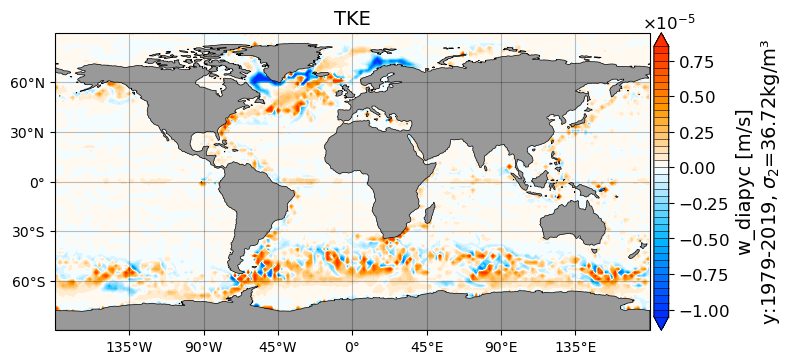

 --> elapsed time: 0.01181198755900065 min


In [7]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
spath  = save_path
sname  = list(wdiap_list[0].keys())[0] #vname
slabel = wdiap_list[0][sname].attrs['str_lsave']
if spath != None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(wdiap_list)])    
nrow   = np.ceil(len(wdiap_list)/ncolumn).astype('int')
if save_fname != None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02]     
# cinfo = dict({'cstr':'blue2red', 'crange':[-1.5e-5, 1.5e-5, 0.0] })
# fig, ax, cbar = tpv.plot_hslice(mesh, wdiap_list, cinfo=cinfo, box=box, n_rc=[nrow, ncolumn], 
#                             figsize=[ncolumn*7, nrow*3.5], proj = 'rob', do_plot=do_plot, 
#                             do_lsmask='fesom', do_rescale=do_rescale, title='descript', 
#                             pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
#                             do_save=spath, save_dpi=which_dpi)

fig, ax, cbar = tpv.plot_hslice_reg(mesh, bin_wdiap_list, input_names, box=box, 
                            figsize=[ncolumn*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncolumn], proj=proj, 
                            cinfo=cinfo, do_rescale=do_rescale,         
                            do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,        
                            title='descript', pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)
print(' --> elapsed time: {} min'.format((clock.time()-ts)/60))         